In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.max_columns', 50)

In [2]:
# Load data
df = pd.read_csv("Acutal Testing Data.csv", index_col=0)

In [3]:
df

,A,B,C,D,E,F,G,H,I
0,141.964897,226.352949,146.484337,77.539808,134.944262,32.982797,167.440304,297.091832,3091.003490
1,144.935575,227.882208,145.000811,78.897964,139.777286,33.608131,172.101489,305.086648,3101.989323
2,144.437134,234.666980,149.455145,81.378646,137.287929,33.521216,173.138616,304.388169,3134.173443
3,139.034096,231.480569,146.563009,83.680871,140.464937,32.373154,166.264334,300.779456,3122.525940
4,141.213983,233.275829,147.956318,79.816857,134.809211,31.813596,167.837537,312.957644,3134.811377
...,...,...,...,...,...,...,...,...,...
2504,1297.164867,2994.203816,686.117089,62.320904,78.924931,113.435158,4456.158943,21357.880970,127459.822000
2505,1291.161511,2938.950066,674.352204,62.961496,77.684331,109.623823,4515.854224,22519.939970,127735.030200
2506,1289.726586,2910.861481,673.740238,62.632459,77.276593,107.954424,4682.722399,22005.634000,129251.684400
2507,1291.052193,2985.814154,686.296262,64.223488,79.928203,113.039260,4853.785794,22499.341580,122875.124800


<AxesSubplot:>

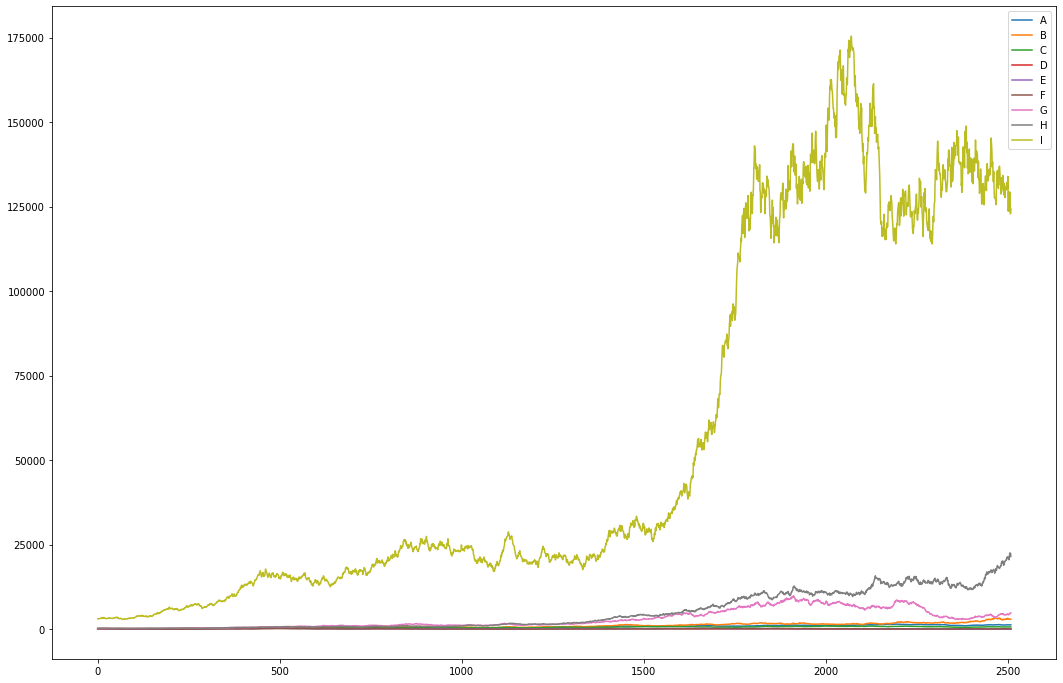

In [4]:
df.plot(figsize=(18, 12))

## Create projections

In [5]:
# Get daily % returns given prices
def make_df(df):
    df['shift']=df[df.columns[0]].shift(1)
    df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100
    df=df.drop(columns='shift')
    return df

In [6]:
# Generate list of projections
def gen_data(df, first_day, runs, days):
    
    # Create list of arrays with projected daily returns
    data=[]
    first_prices=[]
    for x in range(len(df.columns)):
        temp=make_df(df.iloc[:,x:x+1])
        first_prices.append(temp[temp.columns[0]].iloc[first_day-1])
        data.append(np.random.laplace(loc=temp['PctChg'].mean(), scale=temp['PctChg'].std(), size=(runs, days)))
    
    # Get projected prices by applying % changes
    proj_dfs=[]
    for asset_num in range(len(data)):
        
        asset_data=[]
        for n in range(len(data[asset_num])):
            prices=[first_prices[asset_num]]
            for x in range(len(data[asset_num][n])):
                prices.append(prices[x]*(100+data[asset_num][n][x])/100)
            asset_data.append(prices)
        
        proj_arr=np.array(asset_data)
        proj_df=pd.DataFrame()
        for x in range(proj_arr.shape[0]):
            proj_df[str(x)]=proj_arr[x]
        proj_dfs.append(proj_df)
        
    # Transform dataframes
    dfs=[]
    for run_num in range(proj_dfs[0].shape[1]):
        temp=pd.DataFrame()
        for asset_num in range(len(proj_dfs)):
            prev_df=proj_dfs[asset_num]
            temp[str(asset_num)]=prev_df[prev_df.columns[run_num]]
        dfs.append(temp)
        
    return dfs

## Genetic algorithm

In [7]:
# Define global variable for square root of num trading days in a year
year_num=np.sqrt(252)

In [8]:
def gen_weights(df):
    weights=np.random.randint(0, 100000, len(df.columns))
    weights=weights/sum(weights)
    return weights

In [9]:
def gen_population(num_chrom, df):
    population=[]
    for x in range(num_chrom):
        population.append(gen_weights(df))
    return np.array(population)

In [10]:
def evaluate_chrom(chromosome, dfs):    
    sharpes=[]
    for x in range(len(dfs)):
        temp=dfs[x].multiply(chromosome, axis=1)
        test=temp[list(temp.columns)].sum(axis=1).pct_change()
        sharpe=(test.mean()/test.std())*year_num
        sharpes.append(sharpe)
    return np.mean(sharpes)

In [11]:
def evaluate_population(pop, proj_dfs):
    sharpes=[]
    for chrom in pop:
        sharpes.append(evaluate_chrom(chrom, proj_dfs))
    return np.array(sharpes)

In [12]:
# Choose chromosome for next generation given the cumulataive normalized sharpes
def choose_chrom(population, cum_norm_sharpes):
    for n in range(len(cum_norm_sharpes)):
        if cum_norm_sharpes[n]>np.random.rand(1)[0]:
            return population[n]

In [13]:
def crossover(chrom1, chrom2):
    if np.random.rand(1)[0]>.5:
        return np.concatenate((chrom1[:int(len(chrom1)/2)], chrom2[int(len(chrom1)/2):]), axis=None)
    else:
        return np.concatenate((chrom2[:int(len(chrom1)/2)], chrom1[int(len(chrom1)/2):]), axis=None)

In [14]:
def mutate(chrom, rate):
    new=[]
    for weight in chrom:
        if np.random.rand(1)[0]<rate:
            new_weight=weight*(1+np.random.normal(0, .4, 1)[0])
            if(new_weight<0):
                new.append(0)
            else:
                new.append(new_weight)
        else:
            new.append(weight)
    return np.array(new)

In [15]:
def rebalance(chrom):
    return chrom/sum(chrom)

In [17]:
# Create next generation of chromosomes (weights)
def next_gen(sharpes, population, mutation_rate):
    
    new_gen=[]
    
    # Select best fourth
    num_chosen_direct=round(len(population)/4)
    temp={}
    for x in range(len(sharpes)):
        temp[x]=sharpes[x]
    temp={k: v for k, v in sorted(temp.items(), key=lambda item: item[1])}
    keys=list(temp.keys())[-1*num_chosen_direct:]
    for x in keys:
        new_gen.append(population[x])
    
    # Select rest through crossover: create cumulative norm fitness list
    norm_sharpes=sharpes/sum(sharpes)
    cum_norm_sharpes=[norm_sharpes[0]]
    for n in range(1, len(norm_sharpes)):
        cum_norm_sharpes.append(cum_norm_sharpes[n-1]+norm_sharpes[n])
    for x in range(len(population)-num_chosen_direct):
        new_gen.append(crossover(choose_chrom(population, cum_norm_sharpes), choose_chrom(population, cum_norm_sharpes)))
        
    # Mutation and rebalance
    final=[]
    for x in new_gen:
        final.append(rebalance(mutate(x, mutation_rate)))
        
    return np.array(final)

In [18]:
def genetic_algo(prev_gen_sharpes, prev_gen, pop_size, mutation_rate, df, proj_dfs):
    
    # Add to high fitness weights dict
    max_sharpe=max(prev_gen_sharpes)
    best_weights=prev_gen[list(prev_gen_sharpes).index(max_sharpe)]
    high_fitness_weights[max_sharpe]=best_weights
    
    # Check convergence
    convergence=False
    if (len(high_fitness_weights)==30):
        convergence=True
    elif (len(high_fitness_weights)>1):
        if max_sharpe<list(high_fitness_weights.keys())[-2]*1.02:
            convergence_count.append(1)
        else:
            convergence_count.append(0)

        if (sum(convergence_count[-20:])==20):
            convergence=True
        else:
            convergence=False
    else:
        convergence_count.append(0)
    
    # Recursive GA
    if (convergence==False):
        print("Generation Number "+str(len(convergence_count)+1))
        print("---Processing")
        print("---Sharpe: "+str(max_sharpe))
        new_gen=next_gen(prev_gen_sharpes, prev_gen, mutation_rate)
        new_gen_sharpes=evaluate_population(new_gen, proj_dfs)
        print("---Done")
        genetic_algo(new_gen_sharpes, new_gen, pop_size, mutation_rate, df, proj_dfs)
    else:
        print("Convergence achieved")

## Test algorithm

In [51]:
# Create projections
proj_dfs=gen_data(df, first_day = 2520-30, runs = 50, days = 2509)

<ipython-input-5-4989a155b21f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift']=df[df.columns[0]].shift(1)
<ipython-input-5-4989a155b21f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PctChg']=(df[df.columns[0]]-df["shift"]).div(df["shift"])*100


<AxesSubplot:>

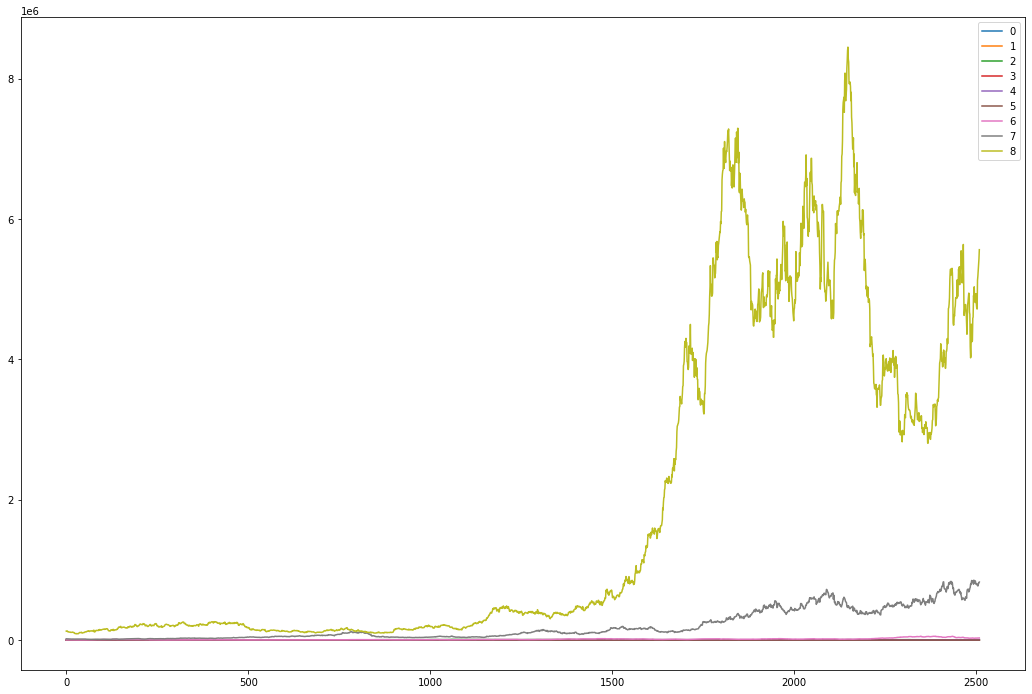

In [52]:
# Plot one set of projections
proj_dfs[0].plot(figsize=(18, 12))

In [53]:
# Define GA inputs
pop_size=25; mutation_rate=.5;

In [54]:
# Create initial population and evaluate
gen1=gen_population(pop_size, df);

In [55]:
# Run GA
sharpes=evaluate_population(gen1, proj_dfs)
high_fitness_weights={}
convergence_count=[]
genetic_algo(sharpes, gen1, pop_size, mutation_rate, df, proj_dfs)

Generation Number 2
---Processing
---Sharpe: 1.2120406958057917
---Done
Generation Number 3
---Processing
---Sharpe: 1.2179810588752815
---Done
Generation Number 4
---Processing
---Sharpe: 1.2313211101652122
---Done
Generation Number 5
---Processing
---Sharpe: 1.2363065268766815
---Done
Generation Number 6
---Processing
---Sharpe: 1.2469380370305216
---Done
Generation Number 7
---Processing
---Sharpe: 1.2685400799130937
---Done
Generation Number 8
---Processing
---Sharpe: 1.270454485775814
---Done
Generation Number 9
---Processing
---Sharpe: 1.2743927875099552
---Done
Generation Number 10
---Processing
---Sharpe: 1.2990703801737202
---Done
Generation Number 11
---Processing
---Sharpe: 1.3046180511867274
---Done
Generation Number 12
---Processing
---Sharpe: 1.3166757720643472
---Done
Generation Number 13
---Processing
---Sharpe: 1.310559934708089
---Done
Generation Number 14
---Processing
---Sharpe: 1.31568568117046
---Done
Generation Number 15
---Processing
---Sharpe: 1.322619600671122

In [56]:
max_sharpe=max(list(high_fitness_weights.items()))[0]
best_weights=max(list(high_fitness_weights.items()))[1]
print("Max Sharpe: "+str(max_sharpe))
print("Associated Weights: "+str(best_weights))

Max Sharpe: 1.3428538993726238
Associated Weights: [0.39265179 0.05788912 0.20330996 0.         0.03913924 0.26858423
 0.02963536 0.00733404 0.00145627]


In [57]:
hi = [arr[1] for arr in list(high_fitness_weights.items())]
hi = np.array(hi)

array([[0.03770504, 0.20931672, 0.06819992, 0.2119328 , 0.0021458 ,
        0.18618325, 0.15545677, 0.10267917, 0.02638053],
       [0.00961616, 0.27898038, 0.01747398, 0.16028314, 0.16873428,
        0.12599547, 0.15988216, 0.05840897, 0.02062547],
       [0.01208302, 0.1359224 , 0.03357494, 0.11733949, 0.07819725,
        0.12755703, 0.3760414 , 0.10518656, 0.01409791],
       [0.3254369 , 0.05359631, 0.00731773, 0.08990827, 0.00251768,
        0.22317981, 0.19652714, 0.08683251, 0.01468365],
       [0.18910932, 0.14275956, 0.15092923, 0.04863601, 0.00248086,
        0.17240038, 0.19365308, 0.08556265, 0.01446891],
       [0.34644633, 0.10577606, 0.02356196, 0.05326786, 0.038414  ,
        0.21175945, 0.1888655 , 0.02573334, 0.00617551],
       [0.3001894 , 0.12344344, 0.02421619, 0.04615562, 0.04645683,
        0.26180291, 0.1636485 , 0.02689364, 0.00719347],
       [0.29900156, 0.1035785 , 0.30287168, 0.02667907, 0.09461065,
        0.09756491, 0.04028168, 0.02824846, 0.0071635 ],


In [60]:
hi.shape

(21, 9)

In [59]:
np.savetxt('weights_genetic.csv', hi, delimiter=',')